# Start

In [1]:
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


read_parameter_card = """
read parameter card
* methanol
*
NONBONDED
CG321    0.0       {CG321EP:.4f}     {CG321RM:.4f}   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       {CLGA1EP:.4f}    {CLGA1RM:.4f} ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END
"""
# HGA2     0.0       -0.0200     1.3400 ! alkane, yin and mackerell, 4/98


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)


import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view


from scipy.optimize import minimize

ev2kcalmol = 1 / (ase.units.kcal / ase.units.mol)

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100

def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)

    with open("total.dmat") as f:
        output_dmat = f.read()

    atom_number_type_dict = {}
    atom_number_resid_dict = {}

    pair_distance_dict = {}
    pair_resid_dict = {}

    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()

            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1

    for _ in output_dmat.split("\n"):
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if atom_number_resid_dict[a] < atom_number_resid_dict[b]:
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (
                    atom_number_resid_dict[a],
                    atom_number_resid_dict[b],
                )

    return {
        "atom_number_type_dict": atom_number_type_dict,
        "atom_number_resid_dict": atom_number_resid_dict,
        "pair_distance_dict": pair_distance_dict,
        "pair_resid_dict": pair_resid_dict,
    }


def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces


def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations


def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations


def calc_pycharmm_dimers(n_mol=20, n_atoms=5, forces=False):
    RANGE = len(dimer_permutations(n_mol))

    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms * n_mol, 3))

    for i, (a, b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f

        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {
        "ele_energies": ele_energies,
        "evdw_energies": evdw_energies,
        "mm_forces": mm_forces,
    }


def reset_block():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


def reset_block_no_internal():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()


import MDAnalysis as mda


def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    atypes = psf.get_atype()
    atc = pycharmm.param.get_atc()
    residues = psf.get_res()
    psf.get_natom()
    # nl_info = capture_neighbour_list()

    # TODO: this assumes a pure system, need to update
    atoms_per_res = int(len(atypes) / len(residues))
    n_res = len(residues)
    resids = np.array([[i] * atoms_per_res for i in range(n_res)]).flatten()
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array(
        [ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names]
    )
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {
        (a - 1, b): i for i, (a, b) in enumerate(zip(mda_resids, atom_names))
    }
    charmm_res_at_dict = {(a, b): i for i, (a, b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k, v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k, v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array(
        [charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))]
    )
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

    return {
        "atom_names": atom_names,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
        "mda_resids": mda_resids,
        "mda_res_at_dict": mda_res_at_dict,
        "charmm_res_at_dict": charmm_res_at_dict,
        "an_charmm_res_at_dict": an_charmm_res_at_dict,
        "an_mda_res_at_dict": an_mda_res_at_dict,
        "atom_positions": atom_positions,
        "reorder": reorder,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
    }


def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda


epsilon = 10 ** (-6)
from e3x.nn import smooth_switch, smooth_cutoff


def combine_with_sigmoid(
    r,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=5.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)

    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy
    mm_contrib = mm_contrib * charmm_off_scale

    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate(
        [
            np.arange(0, n_atoms, 1) + (a - 1) * n_atoms,
            np.arange(0, n_atoms, 1) + (b - 1) * n_atoms,
        ]
    )


def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol + 1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a - 1) * n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))

    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])

        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()

    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, all_monomer_idxs, R):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a, b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0]  # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0]  # TODO: generalize...
        out_dists[i] = np.linalg.norm(R[a] - R[b])

    return out_dists


def setup_ase_atoms(atomic_numbers, positions, n_atoms):
    """Create and setup ASE Atoms object with centered positions"""
    Z = [_ for i, _ in enumerate(atomic_numbers) if i < n_atoms]
    R = np.array([_ for i, _ in enumerate(positions) if i < n_atoms])
    atoms = ase.Atoms(Z, R)
    # translate to center of mass
    # atoms.set_positions(R - R.T.mean(axis=1))
    return atoms


def create_physnet_calculator(params, model, atoms, ev2kcalmol):
    """Create PhysNet calculator with specified parameters"""
    calc = get_ase_calc(
        params,
        model,
        atoms,
        conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol},
    )
    atoms.calc = calc
    return atoms


def initialize_models(restart_path, N_ATOMS_MONOMER):
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)

    # Setup monomer model
    params, monomer_model = get_params_model(restart)
    monomer_model.natoms = N_ATOMS_MONOMER

    # Setup dimer model
    params, dimer_model = get_params_model(restart)
    dimer_model.natoms = N_ATOMS_MONOMER * 2

    return params, monomer_model, dimer_model


def get_rmse_mae(energy, ref_energy):
    rmse = np.sqrt(np.mean((energy - ref_energy) ** 2))
    mae = np.mean(np.abs(energy - ref_energy))
    return rmse, mae


def print_energy_comparison(mmml_energy, charmm, ref_energy):
    """Print comparison of energies with reference data"""

    print("comb")
    print(mmml_energy, ref_energy, abs(mmml_energy - ref_energy))

    print("charmm")
    print(charmm, ref_energy, abs(charmm - ref_energy))


def calculate_E_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM energies"""
    summed_ml_intE = dimer_results["ml_energies"] - monomer_results["ml_energies"][
        np.array(dimer_idxs)
    ].sum(axis=1)
    summed_mm_intE = result["ele_energies"] + result["evdw_energies"]
    return summed_ml_intE, summed_mm_intE

def calculate_F_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM forces"""
    mono = monomer_results["ml_forces"][
        np.array(dimer_idxs)
    ]
    print(mono.shape)
    a,b,c,d = mono.shape
    mono = mono.reshape(a, b*c, d)
    summed_ml_intF = dimer_results["ml_forces"] - mono
    summed_mm_intF = result["mm_forces"]
    return summed_ml_intF, summed_mm_intF

def get_fnkey(fn):
    fnkey = str(fn).split("/")[-1].split(".")[0].upper()
    fnkey = "_".join(fnkey.split("_")[:3])
    return fnkey

def calc_energies_forces(
    fn, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    set_pycharmm_xyz(atom_positions)
    energy.show()

    ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)
    
    result = None
    summed_2body = None
    mmml_energy = None
    charmm = None

    if DO_MM:
        # Calculate CHARMM energies and forces first
        result = calc_pycharmm_dimers(forces=True)
        summed_2body = result["mm_forces"].sum(axis=0)
        mm_forces = result["mm_forces"]

    all_coordinates = ase_atom_full_system.get_positions()
    dimer_idxs = dimer_permutations(20)

    dimer_pair_c_c_distances = get_dimer_distances(
        dimer_idxs, all_monomer_idxs, all_coordinates
    )

    if DO_ML:
        dimer_results = calc_physnet_via_idx_list(
            all_coordinates, all_dimer_idxs, ase_atoms_dimer
        )

        monomer_results = calc_physnet_via_idx_list(
            all_coordinates, all_monomer_idxs, ase_atoms_monomer
        )

        # Calculate ML and MM energies
        summed_ml_intE, summed_mm_intE = calculate_E_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

        summed_ml_intF, summed_mm_intF = calculate_F_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

    if DO_MM and DO_ML:
        combined_with_switches = combine_with_sigmoid(
            dimer_pair_c_c_distances,
            summed_mm_intE,
            summed_ml_intE,
            MM_CUTON=MM_CUTON,
            MM_CUTOFF=MM_CUTOFF,
            BUFFER=BUFFER,
        )
        (
            mm_contrib,
            ml_contrib,
            charmm_off_scale,
            charmm_on_scale,
            ml_scale,
        ) = combined_with_switches

        mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
        charmm = float(summed_mm_intE.sum())
    else:
        mmml_energy = float(summed_ml_intE.sum())
        charmm = float(summed_mm_intE.sum())

    print(summed_ml_intE.shape, summed_mm_intE.shape)

    mm_forces = summed_mm_intF
    ml_forces = summed_ml_intF


    indices = np.array(all_dimer_idxs).flatten()[:, None].repeat(3, axis=1) + np.array([0, mm_forces.shape[1],  2*mm_forces.shape[1]])
    flattened_ml_dimers = ml_forces.reshape(-1, 3).flatten()
    # indices = np.repeat(np.array(all_dimer_idxs).flatten(), 3)
    mmml_forces = jax.ops.segment_sum(flattened_ml_dimers, indices.flatten()).reshape(mm_forces.shape[1], 3)
    
    # mmml_forces = (mm_forces, ml_forces)


    output_dict = {
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }

    return output_dict

def compare_energies(
    fn,  df, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    energy_forces_dict = calc_energies_forces(fn, DO_ML=DO_ML, DO_MM=DO_MM, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
    mmml_energy = energy_forces_dict["mmml_energy"]
    charmm = energy_forces_dict["charmm"]
    mm_forces = energy_forces_dict["mm_forces"]
    ml_forces = energy_forces_dict["ml_forces"]
    mmml_forces = energy_forces_dict["mmml_forces"]

    # print(fn)
    fnkey = get_fnkey(fn)
    # print(fnkey)
    # print(df)
    if fnkey in df["key"].values:
        df = df[df["key"] == fnkey]
        # print(df)
        ref_energy = df.iloc[0]["Formation Energy (kcal/mol)"]
        if DO_MM:
            err_mmml = mmml_energy - ref_energy
            err_charmm = charmm - ref_energy
        else:
            err_mmml = mmml_energy - ref_energy
            err_charmm = None
    else:
        ref_energy = None
        err_mmml = None
        err_charmm = None

    results_dict = {
        "ref_energy": ref_energy,
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "err_mmml": err_mmml,
        "err_charmm": err_charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }
    return results_dict


def set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM):
    cmd = "PRNLev 5\nWRNLev 5"
    param_card = read_parameter_card.format(
        CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM
    )
    print(param_card)
    pycharmm.lingo.charmm_script(param_card)
    cmd = "PRNLev 0\nWRNLev 0"
    pycharmm.lingo.charmm_script(cmd)


def get_loss_terms(fns, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.01, MM_lambda=1.0, ML_lambda=0.0, DO_MM=True, DO_ML=True):
    import time

    start = time.time()
    err_mmml_list = []
    err_charmm_list = []
    for fn in fns:
        results_dict = compare_energies(fn, df, DO_MM=DO_MM, DO_ML=DO_ML, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
        err_mmml_list.append(results_dict["err_mmml"])
        err_charmm_list.append(results_dict["err_charmm"])
        print(
            "{} {:.1f} {:.1f} {:.1f} {:.1f} {:.1f}".format(
                fn.stem,
                results_dict["ref_energy"],
                results_dict["mmml_energy"],
                results_dict["charmm"],
                results_dict["err_mmml"],
                results_dict["err_charmm"],
            )
        )

    end = time.time()
    print("Finished")
    print("Time taken", end - start)
    print("--------------------------------")
    err_mmml_list = np.array(err_mmml_list)
    err_charmm_list = np.array(err_charmm_list)

    print("RMSE MMML", np.sqrt(np.mean(err_mmml_list**2)))
    print("MAE MMML", np.mean(np.abs(err_mmml_list)))
    print("RMSE Charmm", np.sqrt(np.mean(err_charmm_list**2)))
    print("MAE Charmm", np.mean(np.abs(err_charmm_list)))

    loss = MM_lambda * np.mean(err_mmml_list**2) + ML_lambda * np.mean(err_charmm_list**2)
    return loss, err_mmml_list, err_charmm_list

def get_loss_fn(train_filenames, DO_ML=True, DO_MM=True, NTRAIN=20, MM_CUTON=6.0, MM_lambda=1.0, ML_lambda=0.0):
    def loss_fn(x0):
        print("Starting")
        # random_indices = np.random.randint(0, len(train_filenames),6)
        fns = [train_filenames[i] for i in range(NTRAIN)]
        CG321EP, CG321RM, CLGA1EP, CLGA1RM = x0[:4]
        set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
        loss, _, _ = get_loss_terms(fns, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda, DO_MM=DO_MM, DO_ML=DO_ML)
        print("Loss", loss)
        return loss
    return loss_fn


def ep_scale_loss(x0):
    print("Starting")
    random_indices = np.random.randint(0, len(train_filenames), 4)
    fns = [train_filenames[i] for i in random_indices]
    ep_scale = float(x0)
    set_param_card(CG321EP * ep_scale, CG321RM, CLGA1EP * ep_scale, CLGA1RM)
    loss, _, _ = get_loss_terms(fns)
    print("Loss", loss)
    return loss

def create_initial_simplex(x0, delta=0.0001):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.0001,  # Absolute tolerance on x
            "fatol": 0.0001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.1):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

def get_block(a,b):
    block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
"""
    return block


@jit
def switch_MM(    X,
    mm_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.01,
    debug=False,
):
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    mm_contrib = charmm_on_scale * mm_energy * charmm_off_scale
    return mm_contrib



@jit
def switch_ML(X,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.01,
    debug=False,
):
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy
    return ml_contrib.sum()

switch_ML_grad = jax.grad(switch_ML)
switch_MM_grad = jax.grad(switch_MM)


@jit
def combine_with_sigmoid_E(
    X,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ml_contrib = switch_ML(X,ml_energy)
    mm_contrib = switch_ML(X,mm_energy)
    return mm_contrib + ml_contrib


# DATA
###################################################################
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

print(df)


pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)
pycharmm.lingo.charmm_script(load_dcm)
reset_block_no_internal()






[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-04-05 15:11:16.348032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858676.369886  226653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858676.376684  226653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 15:11:39.674702: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coeff

        Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key  
0                    -41.731

In [295]:


def get_dimer_calculator(
    atomic_numbers, 
    atom_positions,
    MM_CUTON = 6.0,
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """
    N_ATOMS_MONOMER = 5
    N_MONOMERS = 2

    params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

    # Setup monomer calculator
    ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
    ase_atoms_monomer = create_physnet_calculator(
        params, monomer_model, ase_atoms_monomer, ev2kcalmol
    )

    # Setup dimer calculator
    ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
    ase_atoms_dimer = create_physnet_calculator(
        params, dimer_model, ase_atoms_dimer, ev2kcalmol
    )

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))

    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)


    def calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer):
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[:N_ATOMS_MONOMER].T.mean(axis=1) - R[N_ATOMS_MONOMER:].T.mean(axis=1))
        takeidx = 0

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R   
        set_pycharmm_xyz(tmp_coord)
        reset_block()
        a, b = 1, 2  # Select first two residues
        block = get_block(a,b)
        _ = pycharmm.lingo.charmm_script(block)
        energy.show()
        ref_forces_mm = get_forces_pycharmm()

        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()

        # Calculate ML dimer energy and forces
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()

        # Calculate ML monomer 1 energy and forces
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        # Calculate ML monomer 2 energy and forces
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()

        # Calculate force errors relative to reference
        ase_dimer_forces = np.array(ase_dimer_F) 
        # Combine monomer forces and calculate errors
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        # Calculate mixed 1-body/2-body forces and errors
        mixed_1b2b = (2 * ase_dimers_1body_forces) - ase_dimer_forces 

        # Calculate interaction energy (difference between dimer and monomers)
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E  # Interaction energy without MM
        # Apply switching functions to combine ML and MM energies
        final_e1 = combine_with_sigmoid_E(R, chm_d_E, final_energy)
        # Add monomer contributions to final energy
        final_energy = final_e1 + (ase_monomer_E1 + ase_monomer_E2)
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R, chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R, final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R, chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R, final_energy)  # ML switching gradient
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]
        # Combine forces with switching functions
        ml_forces_out = (ase_dimers_1body_forces - ase_dimer_forces) * val_ml_s + grad_ml_s * final_energy 
        mm_forces_out = (chm_ref_dimers) * val_mm_s + grad_mm_s * chm_d_E
        # Combine all force contributions for final forces
        final_forces = ml_forces_out + mm_forces_out + ase_dimers_1body_forces

        outdict = {
            "energy": final_energy,
            "forces": final_forces,
            "dH": final_e1,
            "r_COM": r,
            "charmm_energy": chm_d_E,
            "ml_dimer_energy": ase_dimer_E,
            "ml_monomer_energy_1": ase_monomer_E1,
            "ml_monomer_energy_2": ase_monomer_E2,
            "ml_interaction_energy": (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E,
            "val_mm_s": val_mm_s,
            "val_ml_s": val_ml_s,
            "grad_mm_s": grad_mm_s,
            "grad_ml_s": grad_ml_s,
            "ml_forces_out": ml_forces_out,
            "mm_forces_out": mm_forces_out,
            "ml_dimer_forces": ase_dimer_forces,
            "ml_1body_forces": ase_dimers_1body_forces,
            "charmm_forces": chm_ref_dimers,
            "mixed_1b2b_forces": mixed_1b2b,
        }

        return outdict



    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            output = calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer)
            self.results["energy"] = output[
                "energy"
            ].squeeze()   * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = output[
                "forces"
            ]  * (ase.units.kcal/ase.units.mol)

            # for k, v in output.items():
            #     print(k)
            #     print(np.array(v))

    return AseDimerCalculator(), ase_atoms_monomer, ase_atoms_dimer

In [640]:


def get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,
    MM_CUTON = 14.0,
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """
    N_ATOMS_MONOMER = 5
    N_MONOMERS = 20

    params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

    # Setup monomer calculator
    ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
    ase_atoms_monomer = create_physnet_calculator(
        params, monomer_model, ase_atoms_monomer, ev2kcalmol
    )

    # Setup dimer calculator
    ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
    ase_atoms_dimer = create_physnet_calculator(
        params, dimer_model, ase_atoms_dimer, ev2kcalmol
    )

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(20)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)
    
       
    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)

    def calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer, add_1B=False):
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[:N_ATOMS_MONOMER].T.mean(axis=1) - R[N_ATOMS_MONOMER:].T.mean(axis=1))

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R   
        set_pycharmm_xyz(tmp_coord)
        energy.show()
        reset_block_no_internal()
        a,b=1,2
        block = get_block(a,b)
        _ = pycharmm.lingo.charmm_script(block)
        
        energy.show()
        ref_forces_mm = get_forces_pycharmm()
        
        # chm_d_E = 0
        # final_energy = 0
        # chm_ref_dimers = np.zeros((10,3))
        
        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()
        
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]

        
        # Calculate ML dimer energy and forces
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()

        # Calculate ML monomer 1 energy and forces
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        # Calculate ML monomer 2 energy and forces
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()

        # Calculate force errors relative to reference
        ase_dimer_forces = np.array(ase_dimer_F) 
        # Combine monomer forces and calculate errors
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        # Calculate mixed 1-body/2-body forces and errors
        mixed_1b2b = (2 * ase_dimers_1body_forces) - ase_dimer_forces 

        # Calculate interaction energy (difference between dimer and monomers)
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E  # Interaction energy without MM
        
        # # Apply switching functions to combine ML and MM energies
        # final_e1 = combine_with_sigmoid_E(R, chm_d_E, final_energy)

        # final_energy = final_e1 

        final_forces = 0
        ml_forces_out = 0
        ml_f = (ase_dimers_1body_forces - ase_dimer_forces) 
 
        
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R, chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R, final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R, chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R, final_energy)  # ML switching gradient

        # Combine forces with switching functions
        ml_forces_out = ml_f * val_ml_s + grad_ml_s * final_energy 
        if add_1B:
            ml_forces_out += ase_dimers_1body_forces   
            # Add monomer contributions to final energy
            final_energy += (ase_monomer_E1 + ase_monomer_E2)
        mm_forces_out = chm_ref_dimers * val_mm_s + grad_mm_s * chm_d_E
        
        # Combine all force contributions for final forces
        final_forces += ml_forces_out + mm_forces_out #+ ase_dimers_1body_forces
        


        outdict = {
            "energy": final_energy,
            "forces": final_forces,
            # "dH": final_e1,
            # "r_COM": r,
            # "charmm_energy": chm_d_E,
            # "ml_dimer_energy": ase_dimer_E,
            # "ml_monomer_energy_1": ase_monomer_E1,
            # "ml_monomer_energy_2": ase_monomer_E2,
            # "ml_interaction_energy": (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E,
            # "val_mm_s": val_mm_s,
            # "val_ml_s": val_ml_s,
            # "grad_mm_s": grad_mm_s,
            # "grad_ml_s": grad_ml_s,
            # "ml_forces_out": ml_forces_out,
            # "mm_forces_out": mm_forces_out,
            # "ml_dimer_forces": ase_dimer_forces,
            # "ml_1body_forces": ase_dimers_1body_forces,
            # "charmm_forces": chm_ref_dimers,
            # "mixed_1b2b_forces": mixed_1b2b,
        }

        return outdict

    def spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer):
        output = []
        for i, idx in enumerate(all_dimer_idxs):
            do_1B = False
            if collect_monomers[i] == 1:
                do_1B = True
                # print(i, dimer_perms[i])
            output.append(
            calc_dimer_energy_forces(
                R[idx], Z[idx], ase_atoms_dimer, ase_atoms_monomer,  
                add_1B=do_1B))
            # Set up CHARMM coordinates and calculate MM energy
            tmp_coord = coor.get_positions().to_numpy() * 0
            tmp_coord[:len(R), :] = R   
            set_pycharmm_xyz(tmp_coord)
            
        out_E = 0
        out_F = np.zeros((N_ATOMS_MONOMER*N_MONOMERS, 3))
        for i, _ in enumerate(output):
            out_E += output[i]["energy"]
            out_F[all_dimer_idxs[i]] += output[i]["forces"]
            # if output[i]["energy"] < -200:
            #     print(dimer_perms[i], collect_monomers[i], all_dimer_idxs[i])
            #     print(output[i]["energy"])
            #     print(np.array(output[i]["forces"]))
        
        return {"energy": out_E, "forces": out_F}
    



    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            out = spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer)
            self.results["energy"] = out["energy"]  * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = out["forces"] * (ase.units.kcal/ase.units.mol)


    return AseDimerCalculator(), ase_atoms_monomer, ase_atoms_dimer

In [641]:
# tmp_coord = coor.get_positions().to_numpy() * 0
# tmp_coord[:len(R), :] = R   
# tmp_coord
# coor.get_positions()
# set_pycharmm_xyz(tmp_coord)

In [642]:
if 0.0:
    print(".:")

In [643]:
fn = data_path / "dcmk" / "100_lig_2_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17,
       17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,
        1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6,
       17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,
        1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1,
        6, 17, 17,  1,  1,  6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [644]:
system_calc, monomer, dimer_calc_ref = get_spherical_cutoff_calculator(atomic_numbers, atom_positions)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19

read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END



In [659]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions)
ase_atoms_with_calc.calc = system_calc
view_atoms(ase_atoms_with_calc)

In [660]:
indices_of_pairs(1,2), indices_of_pairs(19,20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [661]:
ase_atoms_with_calc.get_potential_energy()

Array gpu:0 -333.380

In [662]:
# np.array(ase_atoms_with_calc.get_forces())

In [663]:
# plt.imshow(np.array(ase_atoms_with_calc.get_forces()))

In [664]:
from ase.calculators.test import gradient_test

# f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,10,1))

In [665]:
np.array(f)

array([[-0.5407605 , -1.6225151 , -0.8123862 ],
       [-0.27671015,  0.67603123, -0.73790073],
       [-0.6996513 , -0.18687381,  0.19792701],
       [ 0.7438884 ,  0.16343243,  0.2828975 ],
       [ 0.7717174 ,  0.96937376,  1.0697644 ],
       [-0.37654072,  1.037531  ,  0.6178003 ],
       [-0.17891721,  0.11540463,  0.4556807 ],
       [ 0.23265424, -0.15706167, -0.7064381 ],
       [ 0.39300093, -0.16188928, -0.32227346],
       [-0.06868108, -0.83343333, -0.0450715 ]], dtype=float32)

In [666]:
np.array(fn)

array(Path('/pchem-data/meuwly/boittier/home/dcm-lj-data/dcmk/100_lig_2_modified.pdb'),
      dtype=object)

In [673]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.001,steps=5)
print()

      Step     Time          Energy          fmax
BFGS:    0 22:43:58     -335.730255        1.609001
BFGS:    1 22:44:06     -335.896271        0.536928
BFGS:    2 22:44:14     -335.930145        0.266214
BFGS:    3 22:44:22     -336.007996        0.235744
BFGS:    4 22:44:31     -336.016022        0.252827
BFGS:    5 22:44:39     -336.033203        0.286404



In [674]:
view_atoms(ase_atoms_with_calc)

In [675]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [679]:
# Parameters.
temperature = 300
timestep_fs = 0.5
num_steps = 10


atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 10 == 0:
      MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
      Stationary(atoms)  # Remove center of mass translation.
      # ZeroRotation(atoms)  # Remove rotations.
      print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")


step     0 epot -335.270 ekin  3.342 etot -331.928


In [680]:
# Write structure to xyz file.
xyz = io.StringIO()
atoms.set_positions(frames[i])
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [681]:
view3d.getModel().setCoordinates(frames, 'array')
view3d.animate({'loop': None, 'interval': 0.1})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

In [ ]:
plt.hist(total_energy - total_energy.mean())

# Load model

In [168]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers = atomic_numbers[:10]
atom_positions = atom_positions[:10]
atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [172]:
dimers_ref_path = Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz")
reorder = np.array([0, 3, 4, 1, 2,])
reorder_dimer = np.concatenate([reorder, reorder+5])

dimers_ref = np.load(dimers_ref_path)
takethese = np.where(dimers_ref["N"] == 10)[0]
len(takethese)

atomic_numbers = dimers_ref["Z"][takethese[0]][reorder_dimer]
atom_positions = dimers_ref["R"][takethese[0]][reorder_dimer]

atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [173]:
dimer_calc, monomer, dimer_calc_ref = get_dimer_calculator(
    atomic_numbers, 
    atom_positions,
)

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END



In [1564]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
atomic_numbers = atomic_numbers[:10]
atom_positions = atom_positions[:10]

In [1565]:
atomic_numbers

array([ 6, 17, 17,  1,  1,  6, 17, 17,  1,  1])

In [1566]:
atom_positions

array([[ -8.022,  -3.036,   9.125],
       [ -6.918,  -4.505,   9.426],
       [ -8.214,  -2.007,  10.652],
       [ -9.022,  -3.429,   8.798],
       [ -7.597,  -2.387,   8.326],
       [-10.285,  -6.393,   6.203],
       [ -9.936,  -7.408,   7.682],
       [ -8.847,  -5.461,   5.681],
       [-11.19 ,  -5.77 ,   6.376],
       [-10.591,  -7.131,   5.372]], dtype=float32)

# Using the calculator

In [1567]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions - atom_positions.T.mean())
ase_atoms_with_calc.calc = dimer_calc

In [1568]:
view_atoms(ase_atoms_with_calc)

In [1572]:
ase_atoms_with_calc.get_potential_energy() 

Array gpu:0 -33.462

In [1573]:
np.array(ase_atoms_with_calc.get_forces())

array([[  6.6063066 , -42.81502   , -44.234913  ],
       [-11.523083  ,  16.154024  ,  17.546793  ],
       [  1.1431472 ,   2.3781912 ,  24.870523  ],
       [ 16.137503  ,  -2.622352  , -11.056332  ],
       [-12.27815   ,   0.4543123 ,  -7.800199  ],
       [ -0.3108634 , -26.714508  ,  16.94655   ],
       [  1.9674072 ,  19.822517  ,  -4.787999  ],
       [ 11.202373  ,  31.518562  ,  15.605632  ],
       [ -8.268384  ,   1.9910778 ,  -6.8231215 ],
       [ -4.6764874 ,  -0.16650303,  -0.26685488]], dtype=float32)

In [1574]:
from ase.calculators.test import gradient_test

f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,10,1))

             eps         max(abs(df))
  0.100000000000 Array gpu:0 46.120
  0.010000000000 Array gpu:0 44.956
  0.001000000000 Array gpu:0 45.080
  0.000100000000 Array gpu:0 42.213
  0.000010000000 Array gpu:0 46.058
  0.000001000000 Array gpu:0 135.202
  0.000000100000 Array gpu:0 732.433
  0.000000010000 Array gpu:0 8.419e+03


In [182]:
np.array(f)

array([[-0.5407605 , -1.6225151 , -0.8123862 ],
       [-0.27671015,  0.67603123, -0.73790073],
       [-0.6996513 , -0.18687381,  0.19792701],
       [ 0.7438884 ,  0.16343243,  0.2828975 ],
       [ 0.7717174 ,  0.96937376,  1.0697644 ],
       [-0.37654072,  1.037531  ,  0.6178003 ],
       [-0.17891721,  0.11540463,  0.4556807 ],
       [ 0.23265424, -0.15706167, -0.7064381 ],
       [ 0.39300093, -0.16188928, -0.32227346],
       [-0.06868108, -0.83343333, -0.0450715 ]], dtype=float32)

In [183]:
np.array(fn)

array([[ 953.67431641,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [ 953.67431641,    0.        ,  953.67431641],
       [ 953.67431641,    0.        ,    0.        ],
       [ 953.67431641,  953.67431641,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        , -953.67431641],
       [ 953.67431641,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ]])

In [184]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.0001,steps=10)
print()

      Step     Time          Energy          fmax
BFGS:    0 18:44:44      -33.559818        1.893415
BFGS:    1 18:44:44      -33.670677        0.747618
BFGS:    2 18:44:44      -33.715801        0.532851
BFGS:    3 18:44:44      -33.737389        0.362372
BFGS:    4 18:44:44      -33.745781        0.304938
BFGS:    5 18:44:44      -33.752769        0.238340
BFGS:    6 18:44:44      -33.755463        0.158404
BFGS:    7 18:44:44      -33.756371        0.061647
BFGS:    8 18:44:44      -33.756657        0.050189
BFGS:    9 18:44:44      -33.757202        0.050573
BFGS:   10 18:44:44      -33.757214        0.028267



In [185]:
view_atoms(ase_atoms_with_calc)

In [187]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [188]:
# Parameters.
temperature = 300
timestep_fs = 0.125
num_steps = 100


atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -33.757 ekin  0.517 etot -33.240


In [689]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [690]:
# view3d.getModel().setCoordinates(frames, 'array')
# view3d.animate({'loop': None, 'interval': 0.1})
# view3d.show()

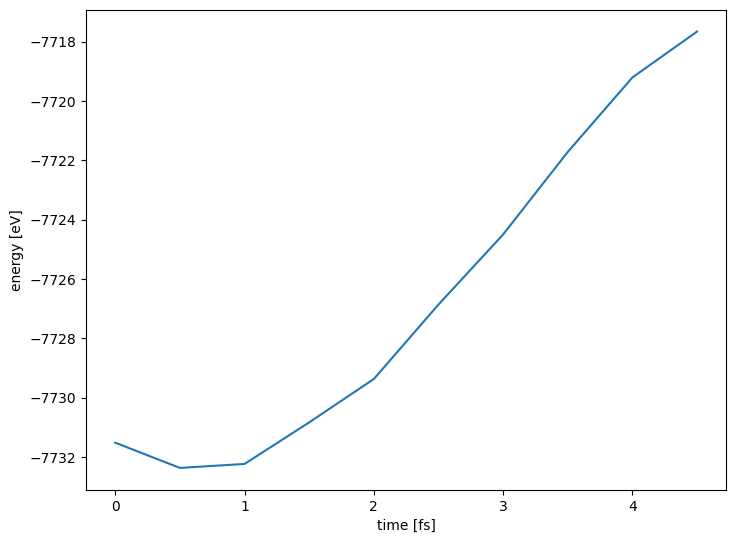

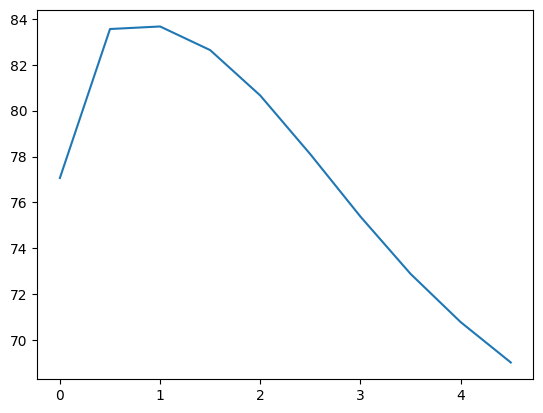

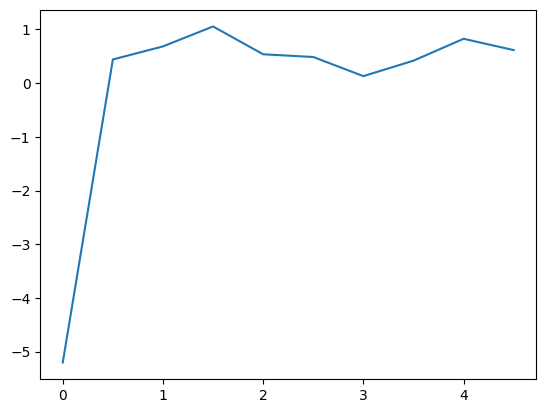

In [691]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

(array([1., 0., 0., 0., 0., 0., 0., 0., 2., 7.]),
 array([-0.22556763, -0.1984314 , -0.17129517, -0.14415894, -0.11702271,
        -0.08988647, -0.06275024, -0.03561401, -0.00847778,  0.01865845,
         0.04579468]),
 <BarContainer object of 10 artists>)

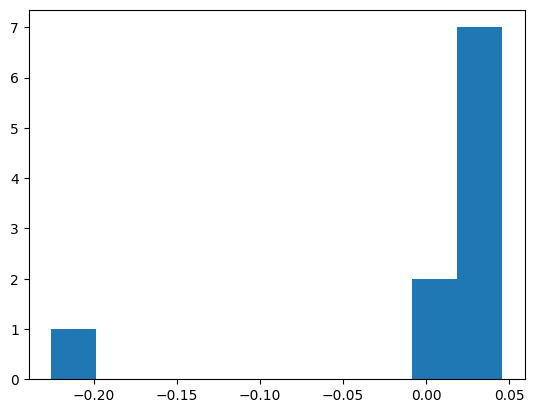

In [692]:
plt.hist(total_energy - total_energy.mean())

In [ ]:

def get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,
    MM_CUTON = 14.0,
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """
    N_ATOMS_MONOMER = 5
    N_MONOMERS = 20

    params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

    # Setup monomer calculator
    ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
    ase_atoms_monomer = create_physnet_calculator(
        params, monomer_model, ase_atoms_monomer, ev2kcalmol
    )

    # Setup dimer calculator
    ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
    ase_atoms_dimer = create_physnet_calculator(
        params, dimer_model, ase_atoms_dimer, ev2kcalmol
    )

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(20)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)
    
       
    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)

    def calc_dimer_energy_forces(R, Z, ase_atoms_dimer, ase_atoms_monomer, add_1B=False):
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[:N_ATOMS_MONOMER].T.mean(axis=1) - R[N_ATOMS_MONOMER:].T.mean(axis=1))

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R   
        set_pycharmm_xyz(tmp_coord)
        energy.show()
        reset_block_no_internal()
        a,b=1,2
        block = get_block(a,b)
        _ = pycharmm.lingo.charmm_script(block)
        
        energy.show()
        ref_forces_mm = get_forces_pycharmm()
        
        # chm_d_E = 0
        # final_energy = 0
        # chm_ref_dimers = np.zeros((10,3))
        
        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()
        
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]

        
        # Calculate ML dimer energy and forces
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()

        # Calculate ML monomer 1 energy and forces
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        # Calculate ML monomer 2 energy and forces
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()

        # Calculate force errors relative to reference
        ase_dimer_forces = np.array(ase_dimer_F) 
        # Combine monomer forces and calculate errors
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        # Calculate mixed 1-body/2-body forces and errors
        mixed_1b2b = (2 * ase_dimers_1body_forces) - ase_dimer_forces 

        # Calculate interaction energy (difference between dimer and monomers)
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E  # Interaction energy without MM
        
        # # Apply switching functions to combine ML and MM energies
        # final_e1 = combine_with_sigmoid_E(R, chm_d_E, final_energy)

        # final_energy = final_e1 

        final_forces = 0
        ml_forces_out = 0
        ml_f = (ase_dimers_1body_forces - ase_dimer_forces) 
 
        
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R, chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R, final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R, chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R, final_energy)  # ML switching gradient

        # Combine forces with switching functions
        ml_forces_out = ml_f * val_ml_s + grad_ml_s * final_energy 
        if add_1B:
            ml_forces_out += ase_dimers_1body_forces   
            # Add monomer contributions to final energy
            final_energy += (ase_monomer_E1 + ase_monomer_E2)
        mm_forces_out = chm_ref_dimers * val_mm_s + grad_mm_s * chm_d_E
        
        # Combine all force contributions for final forces
        final_forces += ml_forces_out + mm_forces_out #+ ase_dimers_1body_forces
        


        outdict = {
            "energy": final_energy,
            "forces": final_forces,
            # "dH": final_e1,
            # "r_COM": r,
            # "charmm_energy": chm_d_E,
            # "ml_dimer_energy": ase_dimer_E,
            # "ml_monomer_energy_1": ase_monomer_E1,
            # "ml_monomer_energy_2": ase_monomer_E2,
            # "ml_interaction_energy": (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E,
            # "val_mm_s": val_mm_s,
            # "val_ml_s": val_ml_s,
            # "grad_mm_s": grad_mm_s,
            # "grad_ml_s": grad_ml_s,
            # "ml_forces_out": ml_forces_out,
            # "mm_forces_out": mm_forces_out,
            # "ml_dimer_forces": ase_dimer_forces,
            # "ml_1body_forces": ase_dimers_1body_forces,
            # "charmm_forces": chm_ref_dimers,
            # "mixed_1b2b_forces": mixed_1b2b,
        }

        return outdict

    def spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer):
        output = []
        for i, idx in enumerate(all_dimer_idxs):
            do_1B = False
            if collect_monomers[i] == 1:
                do_1B = True
                # print(i, dimer_perms[i])
            output.append(
            calc_dimer_energy_forces(
                R[idx], Z[idx], ase_atoms_dimer, ase_atoms_monomer,  
                add_1B=do_1B))
            # Set up CHARMM coordinates and calculate MM energy
            tmp_coord = coor.get_positions().to_numpy() * 0
            tmp_coord[:len(R), :] = R   
            set_pycharmm_xyz(tmp_coord)
            
        out_E = 0
        out_F = np.zeros((N_ATOMS_MONOMER*N_MONOMERS, 3))
        for i, _ in enumerate(output):
            out_E += output[i]["energy"]
            out_F[all_dimer_idxs[i]] += output[i]["forces"]
            # if output[i]["energy"] < -200:
            #     print(dimer_perms[i], collect_monomers[i], all_dimer_idxs[i])
            #     print(output[i]["energy"])
            #     print(np.array(output[i]["forces"]))
        
        return {"energy": out_E, "forces": out_F}
    



    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            out = spherical_cutoff_calculator(R, Z, ase_atoms_dimer, ase_atoms_monomer)
            self.results["energy"] = out["energy"]  * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = out["forces"] * (ase.units.kcal/ase.units.mol)


    return AseDimerCalculator(), ase_atoms_monomer, ase_atoms_dimer

In [687]:
restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1")

"""Initialize monomer and dimer models from restart"""
restart = get_last(restart_path)

# Setup monomer model
params, MODEL = get_params_model(restart)
MODEL.natoms = 10


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

In [688]:
    # def __call__(
    #     self,
    #     atomic_numbers: jnp.ndarray,
    #     positions: jnp.ndarray,
    #     dst_idx: jnp.ndarray,
    #     src_idx: jnp.ndarray,
    #     batch_segments: Optional[jnp.ndarray] = None,
    #     batch_size: Optional[int] = None,
    #     batch_mask: Optional[jnp.ndarray] = None,
    #     atom_mask: Optional[jnp.ndarray] = None,
    # ) -> Dict[str, Optional[jnp.ndarray]]:

# batch segments = Monomer 1 ... Monomer 2 ... Monomer N. Pair 1 ... Pair N ... 

In [694]:
R = ase_atoms_with_calc.get_positions()
Z = ase_atoms_with_calc.get_atomic_numbers()

In [790]:
N_MONOMER = 20
N_ATOMS_PER_MONOMER = 5
N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
dimer_perms = dimer_permutations(N_MONOMER)
N_PAIRS = len(dimer_perms)
REPEATS = N_MONOMER + N_PAIRS
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)
N_dst = len(dst_idx)
dst_idx = np.repeat(dst_idx, REPEATS)
src_idx = np.repeat(src_idx, REPEATS)
monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
dimer_mask = np.ones(N_ATOMS_PER_DIMER)
all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
batch_mask = (np.ones(
    (len(all_atom_masks), N_dst)) * np.arange(1, len(all_atom_masks)+1)[:, None]
             ).flatten()

In [796]:
all_atom_masks = np.array(all_atom_masks, dtype=np.int32).flatten()
all_atom_masks

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [792]:
batch_segments = batch_mask - 1 
batch_size = REPEATS

In [793]:
e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)

(Array[90] i32 x∈[0, 9] μ=4.500 σ=2.872 gpu:0,
 Array[90] i32 x∈[0, 9] μ=4.500 σ=2.872 gpu:0)

In [794]:
(np.ones(
    (len(all_atom_masks), N_dst)) 
             ).flatten()

array([1., 1., 1., ..., 1., 1., 1.])

In [1356]:
MODEL.charges = False
MODEL

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = False
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)

In [1357]:
def get_energy_fn():
    N_MONOMER = 20
    N_ATOMS_PER_MONOMER = 5
    N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
    dimer_perms = dimer_permutations(N_MONOMER)
    N_PAIRS = len(dimer_perms)
    REPEATS = N_MONOMER + N_PAIRS

    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)
    N_dst = len(dst_idx)
    dst_idx = np.repeat(dst_idx, REPEATS)
    src_idx = np.repeat(src_idx, REPEATS)
    monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
    monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
    dimer_mask = np.ones(N_ATOMS_PER_DIMER)
    all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
    batch_mask = (np.ones(
    (len(all_atom_masks), N_dst)) * np.arange(1, len(all_atom_masks)+1)[:, None]
             ).flatten()
    batch_mask = jnp.array(batch_mask, dtype=jnp.int32)
    atom_mask = np.ones_like(Z, dtype=np.int32)
    batch_segments = np.zeros_like(Z, dtype=np.int32) + np.arange(1,101)[:,None] 
    batch_size = REPEATS

    for _ in [Z, R, dst_idx, src_idx, batch_segments,
              jnp.ones_like(dst_idx), jnp.ones_like(Z)]:
        _ = jnp.array(_)
    
    @jax.jit
    def apply_model(atomic_numbers, positions):
        return MODEL.apply(
            params,
            atomic_numbers=atomic_numbers,
            positions=positions,
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments = batch_segments,
            batch_size = REPEATS,
            batch_mask = batch_mask,
            atom_mask=atom_mask
        )

    return apply_model 
    
apply_model = get_energy_fn()

In [1358]:
N_ATOMS_MONOMER = 5
N_MONOMERS = 20

params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

# Setup monomer calculator
ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
ase_atoms_monomer = create_physnet_calculator(
    params, monomer_model, ase_atoms_monomer, ev2kcalmol
)

# Setup dimer calculator
ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
ase_atoms_dimer = create_physnet_calculator(
    params, dimer_model, ase_atoms_dimer, ev2kcalmol
)


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

In [1359]:
ase_atoms_monomer.set_atomic_numbers(Z_2b[:5])
ase_atoms_monomer.set_positions( R_2b[:5])
ase_atoms_monomer.get_potential_energy()

Array gpu:0 -388.677

In [1360]:
all_atom_masks.shape

AttributeError: 'list' object has no attribute 'shape'

In [1361]:
batch_segments.shape

(2000, 2000)

In [1362]:
args = [jnp.array(_) for _ in [Z, R]] #, dst_idx, src_idx, batch_segments, jnp.ones_like(dst_idx), jnp.ones_like(Z)]]
apply_model(*args)

{'charges': None,
 'dipoles': None,
 'electrostatics': None,
 'energy': Array[210, 1, 1, 1] x∈[-1.079e+14, 0.] μ=-5.137e+13 σ=5.388e+13 gpu:0,
 'forces': Array[100, 3] n=300 (1.2Kb) x∈[-1.311e+17, 1.028e+17] μ=1.681e+10 σ=1.793e+16 gpu:0,
 'repulsion': Array gpu:0 0.,
 'sum_charges': None}

In [1363]:
for _ in args:
    print(_.shape)

(100,)
(100, 3)


In [1364]:
N_MONOMERS = 20
all_dimer_idxs = []
for a, b in dimer_permutations(N_MONOMERS):
    all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

all_monomer_idxs = []
for a in range(1, N_MONOMERS + 1):
    all_monomer_idxs.append(indices_of_monomer(a))
    
unique_res_ids = []
collect_monomers = []
dimer_perms = dimer_permutations(20)

N_MONOMER = 20
N_ATOMS_PER_MONOMER = 5
N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
dimer_perms = dimer_permutations(N_MONOMER)
N_PAIRS = len(dimer_perms)
REPEATS = N_MONOMER + N_PAIRS

dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)
N_dst = len(dst_idx)
dst_idx = np.repeat(dst_idx, REPEATS)
src_idx = np.repeat(src_idx, REPEATS)
monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
dimer_mask = np.ones(N_ATOMS_PER_DIMER)
all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
batch_mask = (np.ones(
(len(all_atom_masks), N_dst)) * np.arange(1, len(all_atom_masks)+1)[:, None]
         ).flatten()
batch_mask = jnp.array(batch_mask, dtype=jnp.int32)
atom_mask = np.ones_like(Z, dtype=np.int32)
batch_segments = np.zeros_like(Z, dtype=np.int32) + np.arange(1,101)[:,None] 
batch_size = REPEATS

In [1365]:
np.array(all_atom_masks).shape

(210, 10)

In [1366]:
Z_2b = np.zeros((5*20+190*10, ))
R_2b = np.zeros((5*20+190*10, 3))
R_2b_segments = np.zeros((5*20+190*10, ))
count = 0
count_i = 1
for _ in all_monomer_idxs:
    # print(_)
    count_prev = count
    count += R[_].shape[0]
    R_2b[count_prev:count,:] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_]
    count_i += 1
    
for _ in all_dimer_idxs:
    # print(_)
    count_prev = count
    count += R[_].shape[0]
    R_2b[count_prev:count, :] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_]
    count_i += 1

In [1367]:
R_2b

array([[-7.99960324, -3.0874791 ,  9.14489507],
       [-6.91944648, -4.44166408,  9.39148527],
       [-8.21940515, -2.03754371, 10.55702333],
       ...,
       [-4.55498286,  0.59097554,  7.72045691],
       [-5.4637073 , -1.30824866,  8.8129341 ],
       [-3.88459441, -0.88064375,  9.31357545]])

In [1368]:
Z_2b

array([ 6., 17., 17., ..., 17.,  1.,  1.])

In [1369]:
R_repeated.shape

(21000, 3)

In [1370]:
np.array(all_monomer_idxs).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [1371]:
np.concatenate(np.array(all_dimer_idxs))

array([ 0,  1,  2, ..., 97, 98, 99])

In [1372]:
R_2b[:count,:]

array([[-7.99960324, -3.0874791 ,  9.14489507],
       [-6.91944648, -4.44166408,  9.39148527],
       [-8.21940515, -2.03754371, 10.55702333],
       ...,
       [-4.55498286,  0.59097554,  7.72045691],
       [-5.4637073 , -1.30824866,  8.8129341 ],
       [-3.88459441, -0.88064375,  9.31357545]])

In [1373]:
N_MONOMER = 20
N_ATOMS_PER_MONOMER = 5
N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
dimer_perms = dimer_permutations(N_MONOMER)
N_PAIRS = len(dimer_perms)
REPEATS = N_MONOMER + N_PAIRS

dst_idx_monomer, src_idx_monomer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_MONOMER)
dst_idx_dimer, src_idx_dimer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)

N_dst = len(dst_idx)
dst_idx1 = np.repeat(dst_idx_monomer[None,:], N_MONOMER, axis=0)
src_idx1 = np.repeat(dst_idx_monomer[None, :], N_MONOMER, axis=0)
dst_idx1 = np.array(dst_idx1 + (np.arange(N_MONOMER) * 5)[None, :].T)
src_idx1 = np.array(src_idx1 + (np.arange(N_MONOMER) * 5)[None, :].T)

dst_idx2 = np.repeat(dst_idx_dimer[None,:], N_PAIRS, axis=0)
src_idx2 = np.repeat(src_idx_dimer[None,:], N_PAIRS, axis=0)
dst_idx2 = np.array(dst_idx2 + (np.arange(N_PAIRS) * 10 + 100)[None, :].T)
src_idx2 = np.array(src_idx2 + (np.arange(N_PAIRS) * 10 + 100)[None, :].T)


all_dst = np.concatenate([dst_idx1.flatten(), dst_idx2.flatten()])
all_src = np.concatenate([src_idx1.flatten(), src_idx2.flatten()])

In [1374]:
e3x.ops.sparse_pairwise_indices?

Signature: e3x.ops.sparse_pairwise_indices(num: int, mask_self: bool = True) -> Union[Tuple[jaxtyping.Integer[Array, '... num*(num-1)'], jaxtyping.Integer[Array, '... num*(num-1)']], Tuple[jaxtyping.Integer[Array, '... num**2'], jaxtyping.Integer[Array, '... num**2']]]
Docstring:
Generates a sparse index list for all pairs of ``num`` elements.

Args:
  num: Number of elements.
  mask_self: Whether self-connections (loops) should be masked out.

Returns:
  A sparse index list specifying all pairs returned as a tuple ``(dst_idx,
  src_idx)`` with destination and source indices, respectively.
File:      ~/pycharmm_test/.venv/lib/python3.12/site-packages/e3x/ops/indexed.py
Type:      function

In [1493]:
np.arange(N_MONOMER) * 5
np.array(dst_idx_monomer), np.array(src_idx_monomer)

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
       dtype=int32),
 array([1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
       dtype=int32))

In [1451]:
np.array(dst_idx_dimer).shape, np.array(src_idx_dimer)

((90,),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4,
        5, 6, 7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8,
        9, 0, 1, 2, 3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6,
        7, 8], dtype=int32))

In [1376]:
e3x.ops.sparse_pairwise_indices?
REPEATS

210

Signature: e3x.ops.sparse_pairwise_indices(num: int, mask_self: bool = True) -> Union[Tuple[jaxtyping.Integer[Array, '... num*(num-1)'], jaxtyping.Integer[Array, '... num*(num-1)']], Tuple[jaxtyping.Integer[Array, '... num**2'], jaxtyping.Integer[Array, '... num**2']]]
Docstring:
Generates a sparse index list for all pairs of ``num`` elements.

Args:
  num: Number of elements.
  mask_self: Whether self-connections (loops) should be masked out.

Returns:
  A sparse index list specifying all pairs returned as a tuple ``(dst_idx,
  src_idx)`` with destination and source indices, respectively.
File:      ~/pycharmm_test/.venv/lib/python3.12/site-packages/e3x/ops/indexed.py
Type:      function

In [1521]:
def get_energy_fn():
    N_MONOMER = 20
    N_ATOMS_PER_MONOMER = 5
    N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
    dimer_perms = dimer_permutations(N_MONOMER)
    N_PAIRS = len(dimer_perms)
    REPEATS = N_MONOMER + N_PAIRS

    Z_2b = np.zeros((5*20+190*10, ))
    R_2b = np.zeros((5*20+190*10, 3))
    R_2b_segments = np.zeros((5*20+190*10, ))
    
    dst_idx_monomer, src_idx_monomer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_MONOMER)
    dst_idx_dimer, src_idx_dimer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)
    
    dst_idx1 = np.repeat(dst_idx_monomer[None,:], N_MONOMER, axis=0)
    src_idx1 = np.repeat(src_idx_monomer[None, :], N_MONOMER, axis=0)
    
    dst_idx1 = np.array(dst_idx1 + (np.arange(N_MONOMER) * 5)[:, None]).flatten()
    src_idx1 = np.array(src_idx1 + (np.arange(N_MONOMER) * 5)[:, None]).flatten()
    
    dst_idx2 = np.repeat(dst_idx_dimer[None,:] , N_PAIRS, axis=0)
    src_idx2 = np.repeat(src_idx_dimer[None,:] , N_PAIRS, axis=0)
    
    dst_idx2 = np.array(dst_idx2 + (np.arange(N_PAIRS) * 10 + 100)[ :, None]).flatten()
    src_idx2 = np.array(src_idx2 + (np.arange(N_PAIRS) * 10 + 100)[:, None]).flatten()
    
    
    all_dst = np.concatenate([dst_idx1, dst_idx2])
    all_src = np.concatenate([src_idx1, src_idx2])

    N_dst = len(all_dst)

    
    monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
    monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
    dimer_mask = np.ones(N_ATOMS_PER_DIMER)
    all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
    batch_mask = np.ones_like(all_dst)
    batch_mask = jnp.array(batch_mask, dtype=jnp.int32)
    batch_segments = np.ones_like(Z_2b, dtype=np.int32) + np.arange(1,len(Z_2b)+1)[:,None] 
    batch_size = REPEATS
    

    count = 0
    count_i = 0
    for _ in all_monomer_idxs:
        count_prev = count
        print(_)
        count += R[_].shape[0]
        print(count_prev,count)
        R_2b[count_prev:count,:] = R[_] 
        print()
        print(all_dst[count_i*20:count_i*20+20])
        print(all_src[count_i*20:count_i*20+20])
        print()
        R_2b_segments[count_prev:count] = np.zeros_like(_) + count_i
        Z_2b[count_prev:count] = Z[_] 
        
        count_i += 1

    mcount = count_i
    for _ in all_dimer_idxs:
        count_prev = count
        print(_)
        count += R[_].shape[0]
        print(count_prev,count)
        R_2b[count_prev:count, :] = R[_] 

        print()
        shift = 20 * 20
        _count = count_i - mcount
        print(all_dst[shift + _count*90: shift + _count*90+90])
        print(all_src[shift + _count*90: shift + _count*90+90])
        print()
        
        R_2b_segments[count_prev:count] = np.zeros_like(_) + count_i
        Z_2b[count_prev:count] = Z[_]
        
        count_i += 1
        
    atom_mask = np.ones_like(Z_2b, dtype=np.int32)
    
    
    for _ in [batch_mask, Z_2b, R_2b, all_dst, all_src, R_2b_segments,
              jnp.ones_like(all_dst), jnp.ones_like(Z_2b)]:
        _ = jnp.array(_)
        print(_)
        
    Z_2b = jnp.array(Z_2b, dtype=jnp.int32)
    print(np.array(R_2b_segments))
    
    @jax.jit
    def apply_model(atomic_numbers, positions):
        return MODEL.apply(
            params,
            atomic_numbers=atomic_numbers,
            positions=positions,
            dst_idx=all_dst,
            src_idx=all_src,
            batch_segments = jnp.array(R_2b_segments, dtype=jnp.int32),
            batch_size = REPEATS,
            batch_mask = np.ones_like(all_dst),
            atom_mask = atom_mask
        )

    return apply_model 
    
apply_model = get_energy_fn()

[0 1 2 3 4]
0 5

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[1 2 3 4 0 2 3 4 0 1 3 4 0 1 2 4 0 1 2 3]

[5 6 7 8 9]
5 10

[5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9 9 9 9]
[6 7 8 9 5 7 8 9 5 6 8 9 5 6 7 9 5 6 7 8]

[10 11 12 13 14]
10 15

[10 10 10 10 11 11 11 11 12 12 12 12 13 13 13 13 14 14 14 14]
[11 12 13 14 10 12 13 14 10 11 13 14 10 11 12 14 10 11 12 13]

[15 16 17 18 19]
15 20

[15 15 15 15 16 16 16 16 17 17 17 17 18 18 18 18 19 19 19 19]
[16 17 18 19 15 17 18 19 15 16 18 19 15 16 17 19 15 16 17 18]

[20 21 22 23 24]
20 25

[20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23 24 24 24 24]
[21 22 23 24 20 22 23 24 20 21 23 24 20 21 22 24 20 21 22 23]

[25 26 27 28 29]
25 30

[25 25 25 25 26 26 26 26 27 27 27 27 28 28 28 28 29 29 29 29]
[26 27 28 29 25 27 28 29 25 26 28 29 25 26 27 29 25 26 27 28]

[30 31 32 33 34]
30 35

[30 30 30 30 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34]
[31 32 33 34 30 32 33 34 30 31 33 34 30 31 32 34 30 31 32 33]

[35 36 37 38 39]
35 40

[35 35 35 35 36 36 36 36 3

In [ ]:
Z_2b = jnp.array(Z_2b, dtype=jnp.int32)
R_2b = jnp.array(R_2b, dtype=jnp.float32)
output = apply_model(Z_2b, R_2b)

In [1514]:
(np.array(output["energy"]) / (ase.units.kcal/ase.units.mol)).flatten()

array([-241.89317, -241.94678, -241.77454, -241.30159, -240.8887 ,
       -240.60333, -240.57927, -241.73602, -242.26543, -241.8042 ,
       -242.51746, -242.0518 , -242.20274, -240.95517, -241.66861,
       -242.3957 , -242.55647, -242.12088, -240.86197, -240.9062 ,
       -322.22046, -332.97244, -318.32965, -430.72864, -327.71796,
       -313.32297, -337.43918, -334.834  , -337.46317, -332.45312,
       -346.1177 , -327.7095 , -356.4939 , -359.17276, -352.34906,
       -419.395  , -397.99545, -380.73093, -313.4801 , -337.25177,
       -371.98184, -459.0032 , -328.47958, -322.47467, -483.68695,
       -423.6277 , -471.50647, -331.0534 , -435.9975 , -317.2875 ,
       -471.791  , -471.9649 , -319.39386, -329.88965, -316.62665,
       -329.94696, -412.97205, -397.68484, -482.6572 , -427.55798,
       -316.57117, -478.39493, -480.31757, -457.67255, -457.38388,
       -307.64105, -329.52863, -482.7236 , -376.45453, -479.64743,
       -481.4643 , -412.88412, -323.1379 , -328.61258, -479.01

In [1515]:
Z_2b

Array[2000] i32 7.8Kb x∈[1, 17] μ=8.400 σ=7.255 gpu:0

In [1516]:
output.keys()
np.array(R_2b_segments, dtype=jnp.int32)

array([  1,   1,   1, ..., 210, 210, 210], dtype=int32)

In [1517]:
ase_atoms_monomer.set_atomic_numbers(Z_2b[20:25])
ase_atoms_monomer.set_positions( R_2b[20:25])
ase_atoms_monomer.get_potential_energy()

Array gpu:0 -387.804

In [1518]:
view_atoms(ase_atoms_monomer)

(0.0, 2.0)

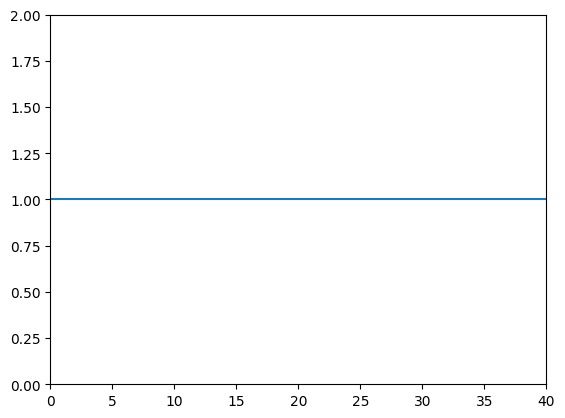

In [1519]:
plt.plot(batch_mask)
plt.xlim(0,40)
plt.ylim(0,2)

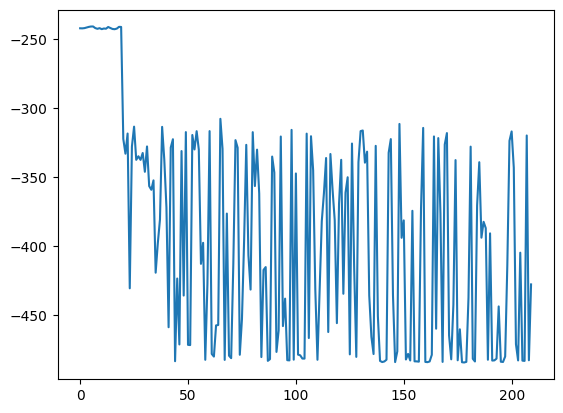

In [1520]:
e = np.array(output["energy"]).flatten() / (ase.units.kcal/ase.units.mol)
plt.plot(e)

(0.0, 40.0)

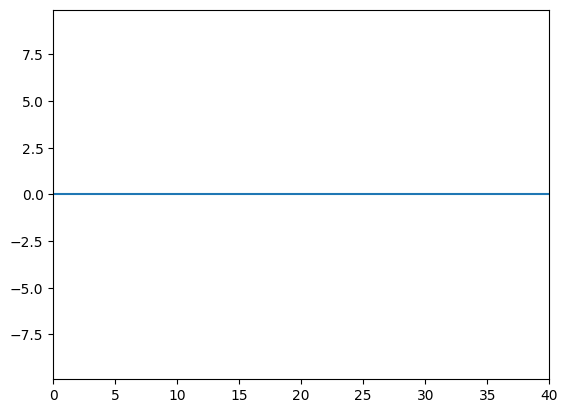

In [1437]:
plt.plot(all_src - all_dst)
plt.xlim(0, 40)

In [1332]:
np.array(output["forces"])

array([[ 0.9305929 , -0.18680252,  0.53895235],
       [ 0.2502473 , -0.5914117 , -0.17045146],
       [-0.32464224,  0.70056605,  0.56161565],
       ...,
       [ 0.20062158,  0.7199707 , -0.08317062],
       [-1.2125666 , -0.89496624, -0.10446787],
       [ 2.4082582 , -0.68763494,  1.0668966 ]], dtype=float32)

In [1333]:
N_MONOMER = 20
N_ATOMS_PER_MONOMER = 5
N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
dimer_perms = dimer_permutations(N_MONOMER)
N_PAIRS = len(dimer_perms)
REPEATS = N_MONOMER + N_PAIRS

Z_2b = np.zeros((5*20+190*10, ))
R_2b = np.zeros((5*20+190*10, 3))
R_2b_segments = np.zeros((5*20+190*10, ))

dst_idx_monomer, src_idx_monomer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_MONOMER)
dst_idx_dimer, src_idx_dimer = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)

dst_idx1 = np.repeat(dst_idx_monomer[None,:], N_MONOMER, axis=0)
src_idx1 = np.repeat(src_idx_monomer[None, :], N_MONOMER, axis=0)
dst_idx1 = np.array(dst_idx1 + (np.arange(N_MONOMER) * 5)[None, :].T)
src_idx1 = np.array(src_idx1 + (np.arange(N_MONOMER) * 5)[None, :].T)

dst_idx2 = np.repeat(dst_idx_dimer[None,:], N_PAIRS, axis=0)
src_idx2 = np.repeat(src_idx_dimer[None,:], N_PAIRS, axis=0)
dst_idx2 = np.array(dst_idx2 + (np.arange(N_PAIRS) * 10 + 5 * 20)[ :, None])
src_idx2 = np.array(src_idx2 + (np.arange(N_PAIRS) * 10 + 5 * 20)[:, None])


all_dst = np.concatenate([dst_idx1.flatten(), dst_idx2.flatten()])
all_src = np.concatenate([src_idx1.flatten(), src_idx2.flatten()])

N_dst = len(all_dst)


monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
dimer_mask = np.ones(N_ATOMS_PER_DIMER)
all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
batch_mask = np.ones_like(all_dst)
# batch_mask = (np.ones(
# (len(all_atom_masks), N_dst)) * np.arange(1, len(all_atom_masks)+1)[:, None]
#          ).flatten()
batch_mask = jnp.array(batch_mask, dtype=jnp.int32)
batch_segments = np.zeros_like(Z_2b, dtype=np.int32) + np.arange(1,len(Z_2b)+1)[:,None] 
batch_size = REPEATS


count = 0
count_i = 0
for _ in all_monomer_idxs:
    # print(_)
    count_prev = count
    
    count += R[_].shape[0]
    R_2b[count_prev:count,:] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_] 
    
    count_i += 1
    
for _ in all_dimer_idxs:
    # print(_)
    count_prev = count
    count += R[_].shape[0]
    R_2b[count_prev:count, :] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_]
    count_i += 1
    
atom_mask = np.ones_like(Z_2b, dtype=np.int32)


for _ in [batch_mask, Z_2b, R_2b, all_dst, all_src, R_2b_segments,
          jnp.ones_like(all_dst), jnp.ones_like(Z_2b)]:
    _ = jnp.array(_)
    print(_)
    
Z_2b = jnp.array(Z_2b, dtype=jnp.int32)

Array[17500] i32 68Kb x∈[1, 1] μ=1.000 σ=0. gpu:0
Array[2000] 7.8Kb x∈[1.000, 17.000] μ=8.400 σ=7.255 gpu:0
Array[2000, 3] n=6000 (23Kb) x∈[-17.394, 15.857] μ=-1.244 σ=8.256 gpu:0
Array[17500] i32 68Kb x∈[0, 1999] μ=1.027e+03 σ=562.415 gpu:0
Array[17500] i32 68Kb x∈[0, 1999] μ=1.027e+03 σ=562.415 gpu:0
Array[2000] 7.8Kb x∈[0., 209.000] μ=109.250 σ=58.165 gpu:0
Array[17500] i32 68Kb x∈[1, 1] μ=1.000 σ=0. gpu:0
Array[2000] 7.8Kb x∈[1.000, 1.000] μ=1.000 σ=0. gpu:0


In [1300]:
dst_idx_dimer

Array[90] i32 x∈[0, 9] μ=4.500 σ=2.872 gpu:0

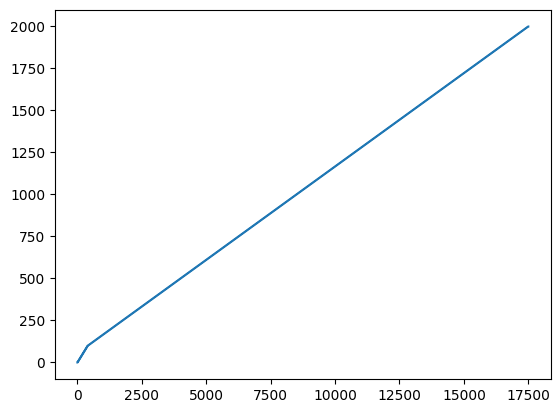

In [1299]:
# plt.plot(np.log(all_dst+1))
plt.plot(all_dst)

In [1210]:
# R[_].shape[0]
all_monomer_idxs[0].shape
all_atom_masks

[array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),


In [1209]:
all_dimer_idxs

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14]),
 array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19]),
 array([ 0,  1,  2,  3,  4, 20, 21, 22, 23, 24]),
 array([ 0,  1,  2,  3,  4, 25, 26, 27, 28, 29]),
 array([ 0,  1,  2,  3,  4, 30, 31, 32, 33, 34]),
 array([ 0,  1,  2,  3,  4, 35, 36, 37, 38, 39]),
 array([ 0,  1,  2,  3,  4, 40, 41, 42, 43, 44]),
 array([ 0,  1,  2,  3,  4, 45, 46, 47, 48, 49]),
 array([ 0,  1,  2,  3,  4, 50, 51, 52, 53, 54]),
 array([ 0,  1,  2,  3,  4, 55, 56, 57, 58, 59]),
 array([ 0,  1,  2,  3,  4, 60, 61, 62, 63, 64]),
 array([ 0,  1,  2,  3,  4, 65, 66, 67, 68, 69]),
 array([ 0,  1,  2,  3,  4, 70, 71, 72, 73, 74]),
 array([ 0,  1,  2,  3,  4, 75, 76, 77, 78, 79]),
 array([ 0,  1,  2,  3,  4, 80, 81, 82, 83, 84]),
 array([ 0,  1,  2,  3,  4, 85, 86, 87, 88, 89]),
 array([ 0,  1,  2,  3,  4, 90, 91, 92, 93, 94]),
 array([ 0,  1,  2,  3,  4, 95, 96, 97, 98, 99]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 5

(0.0, 100.0)

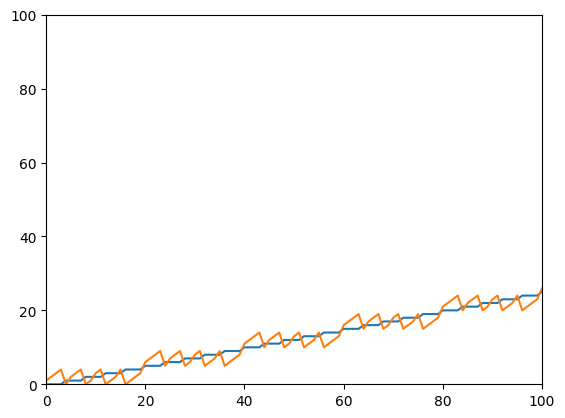

In [1195]:
plt.plot(all_dst)
plt.plot(all_src)
plt.xlim(0,100)
plt.ylim(0,100)

In [1196]:
e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)

(Array[90] i32 x∈[0, 9] μ=4.500 σ=2.872 gpu:0,
 Array[90] i32 x∈[0, 9] μ=4.500 σ=2.872 gpu:0)

In [1087]:
all_dst[:40], all_src[:40]
e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_MONOMER)

(Array[20] i32 x∈[0, 4] μ=2.000 σ=1.414 gpu:0,
 Array[20] i32 x∈[0, 4] μ=2.000 σ=1.414 gpu:0)

In [1547]:
N_MONOMER = 20
N_ATOMS_PER_MONOMER = 5
N_ATOMS_PER_DIMER = N_ATOMS_PER_MONOMER * 2
dimer_perms = dimer_permutations(N_MONOMER)
N_PAIRS = len(dimer_perms)
REPEATS = N_MONOMER + N_PAIRS

dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(N_ATOMS_PER_DIMER)
N_dst = len(dst_idx)
dst_idx = np.repeat(dst_idx[None,:], REPEATS, axis=0)
src_idx = np.repeat(src_idx[None, :], REPEATS, axis=0)
dst_idx = dst_idx + np.arange(210)[:,None]
src_idx = src_idx + np.arange(210)[:,None]

monomer_mask = np.zeros(N_ATOMS_PER_DIMER) 
monomer_mask[:N_ATOMS_PER_MONOMER] = np.ones_like(N_ATOMS_PER_MONOMER)
dimer_mask = np.ones(N_ATOMS_PER_DIMER)
all_atom_masks = [monomer_mask] * N_MONOMER + [dimer_mask] * N_PAIRS
batch_mask = (np.ones(
(len(all_atom_masks), N_dst)) * np.arange(1, len(all_atom_masks)+1)[:, None]
         ).flatten()
batch_mask = jnp.array(batch_mask, dtype=jnp.int32)
batch_segments = np.zeros_like(Z, dtype=np.int32) + np.arange(1,101)[:,None] 
batch_size = REPEATS

Z_2b = np.zeros((5*20+190*10, ))
R_2b = np.zeros((5*20+190*10, 3))
R_2b_segments = np.zeros((5*20+190*10, ))
count = 0
count_i = 1
for _ in all_monomer_idxs:
    # print(_)
    count_prev = count
    count += R[_].shape[0]
    R_2b[count_prev:count,:] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_] 
    count_i += 1
    
for _ in all_dimer_idxs:
    # print(_)
    count_prev = count
    count += R[_].shape[0]
    R_2b[count_prev:count, :] = R[_] 
    R_2b_segments[count_prev:count] = _*0 + count_i
    Z_2b[count_prev:count] = Z[_]
    count_i += 1
    
atom_mask = np.ones_like(Z_2b, dtype=np.int32)


for _ in [Z_2b, R_2b, dst_idx, src_idx, R_2b_segments,
          jnp.ones_like(dst_idx), jnp.ones_like(Z_2b)]:
    _ = jnp.array(_)
    print(_)
    
Z_2b = jnp.array(Z_2b, dtype=jnp.int32)

Array[2000] 7.8Kb x∈[1.000, 17.000] μ=8.400 σ=7.255 gpu:0
Array[2000, 3] n=6000 (23Kb) x∈[-17.394, 15.857] μ=-1.244 σ=8.256 gpu:0
Array[210, 90] i32 n=18900 (74Kb) x∈[0, 218] μ=109.000 σ=60.689 gpu:0
Array[210, 90] i32 n=18900 (74Kb) x∈[0, 218] μ=109.000 σ=60.689 gpu:0
Array[2000] 7.8Kb x∈[1.000, 210.000] μ=110.250 σ=58.165 gpu:0
Array[210, 90] i32 n=18900 (74Kb) x∈[1, 1] μ=1.000 σ=0. gpu:0
Array[2000] 7.8Kb x∈[1.000, 1.000] μ=1.000 σ=0. gpu:0


In [1548]:
np.array(batch_mask)

array([  1,   1,   1, ..., 210, 210, 210], dtype=int32)

In [1549]:
np.array(dst_idx) + np.arange(210)[:,None]

array([[  0,   0,   0, ...,   9,   9,   9],
       [  2,   2,   2, ...,  11,  11,  11],
       [  4,   4,   4, ...,  13,  13,  13],
       ...,
       [414, 414, 414, ..., 423, 423, 423],
       [416, 416, 416, ..., 425, 425, 425],
       [418, 418, 418, ..., 427, 427, 427]])

In [18]:
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
) 

def prepare_batches_md(
    data,
    batch_size: int,
    data_keys = None,
    num_atoms: int = 60,
    dst_idx = None,
    src_idx= None,
    include_id: bool = False,
    debug_mode: bool = False,
) :
    """
    Efficiently prepare batches for training.

    Args:
        key: JAX random key for shuffling.
        data (dict): Dictionary containing the dataset.
            Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
        batch_size (int): Size of each batch.
        data_keys (list, optional): List of keys to include in the output.
            If None, all keys in `data` are included.
        num_atoms (int, optional): Number of atoms per example. Default is 60.
        dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
        src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
        include_id (bool, optional): Whether to include 'id' key if present in data.
        debug_mode (bool, optional): If True, run assertions and extra checks.

    Returns:
        list: A list of dictionaries, each representing a batch.
    """

    # -------------------------------------------------------------------------
    # Validation and Setup
    # -------------------------------------------------------------------------

    # Check for mandatory keys
    required_keys = ["R", "N", "Z"]
    for req_key in required_keys:
        if req_key not in data:
            raise ValueError(f"Data dictionary must contain '{req_key}' key.")

    # Default to all keys in data if none provided
    if data_keys is None:
        data_keys = list(data.keys())

    # Verify data sizes
    data_size = len(data["R"])
    steps_per_epoch = data_size // batch_size
    if steps_per_epoch == 0:
        raise ValueError(
            "Batch size is larger than the dataset size or no full batch available."
        )

    # -------------------------------------------------------------------------
    # Compute Random Permutation for Batches
    # -------------------------------------------------------------------------
    # perms = jax.random.permutation(key, data_size)
    perms = jnp.arange(0, data_size)
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    # -------------------------------------------------------------------------
    # Precompute Batch Segments and Indices
    # -------------------------------------------------------------------------
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    offsets = jnp.arange(batch_size) * num_atoms

    # Compute pairwise indices only if not provided
    # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
    if dst_idx is None or src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

    # Adjust indices for batching
    dst_idx = dst_idx + offsets[:, None]
    src_idx = src_idx + offsets[:, None]

    # Centralize reshape logic
    # For keys not listed here, we default to their original shape after indexing.
    reshape_rules = {
        "R": (batch_size * num_atoms, 3),
        "F": (batch_size * num_atoms, 3),
        "E": (batch_size, 1),
        "Z": (batch_size * num_atoms,),
        "D": (batch_size,3),
        "N": (batch_size,),
        "mono": (batch_size * num_atoms,),
    }

    output = []

    # -------------------------------------------------------------------------
    # Batch Preparation Loop
    # -------------------------------------------------------------------------
    for perm in perms:
        # Build the batch dictionary
        batch = {}
        for k in data_keys:
            if k not in data:
                continue
            v = data[k][[perm]]
            new_shape = reshape_rules.get(k, None)
            if new_shape is not None:
                batch[k] = v.reshape(new_shape)
            else:
                # Default to just attaching the permuted data without reshape
                batch[k] = v

        # Optionally include 'id' if requested and present
        if include_id and "id" in data and "id" in data_keys:
            batch["id"] = data["id"][perm]

        # Compute good_indices (mask for valid atom pairs)
        # Vectorized approach: We know N is shape (batch_size,)
        # Expand N to compare with dst_idx/src_idx
        # dst_idx[i], src_idx[i] range over atom pairs within the ith example
        # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
        # We'll compute this for all i and concatenate.
        N = batch["N"]
        # Expand N and offsets for comparison
        expanded_n = N[:, None] + offsets[:, None]
        valid_dst = dst_idx < expanded_n
        valid_src = src_idx < expanded_n
        good_pairs = (valid_dst & valid_src).astype(jnp.int32)
        good_indices = good_pairs.reshape(-1)

        # Add metadata to the batch
        atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
        batch.update(
            {
                "dst_idx": dst_idx.flatten(),
                "src_idx": src_idx.flatten(),
                "batch_mask": good_indices,
                "batch_segments": batch_segments,
                "atom_mask": atom_mask,
            }
        )

        # Debug checks
        if debug_mode:
            # Check expected shapes
            assert batch["R"].shape == (
                batch_size * num_atoms,
                3,
            ), f"R shape mismatch: {batch['R'].shape}"
            assert batch["F"].shape == (
                batch_size * num_atoms,
                3,
            ), f"F shape mismatch: {batch['F'].shape}"
            assert batch["E"].shape == (
                batch_size,
                1,
            ), f"E shape mismatch: {batch['E'].shape}"
            assert batch["Z"].shape == (
                batch_size * num_atoms,
            ), f"Z shape mismatch: {batch['Z'].shape}"
            assert batch["N"].shape == (
                batch_size,
            ), f"N shape mismatch: {batch['N'].shape}"
            # Optional: print or log if needed

        output.append(batch)

    return output

In [19]:
data = {"R": [], "Z":[], "N": []}

for _ in all_monomer_idxs:
    data["R"].append( R[np.concatenate([_,_])])
    data["Z"].append(Z[np.concatenate([_,_])])
    data["N"].append(5)

for _ in all_dimer_idxs:
    data["R"].append( R[_])
    data["Z"].append(Z[_])
    data["N"].append(10)


data["R"] = np.array(data["R"])
data["Z"] = np.array(data["Z"])
data["N"] =  np.array(data["N"])

batches = prepare_batches_md(data, 210, num_atoms=10)
batches

NameError: name 'all_monomer_idxs' is not defined

In [20]:
# Z_2b = jnp.array(Z_2b[:100], dtype=jnp.int32)
# R_2b = jnp.array(R_2b[:100], dtype=jnp.float32)
output = apply_model(Z, R)

NameError: name 'apply_model' is not defined

In [21]:
segs = np.concatenate([np.array(all_monomer_idxs).flatten(), np.array(all_dimer_idxs).flatten()])
print(segs.shape)
e = output["forces"] *  23.06
# e = e.flatten()
print(e)



NameError: name 'all_monomer_idxs' is not defined

In [1687]:
(np.array(output["energy"]) *  23.06)

array([[[[-388.6188 ]]],


       [[[-387.7049 ]]],


       [[[-388.5242 ]]],


       [[[-387.60587]]],


       [[[-387.69513]]],


       [[[-386.31314]]],


       [[[-385.84784]]],


       [[[-388.0976 ]]],


       [[[-388.4205 ]]],


       [[[-387.6775 ]]],


       [[[-387.39804]]],


       [[[-388.52322]]],


       [[[-387.20645]]],


       [[[-387.37173]]],


       [[[-387.47952]]],


       [[[-386.51093]]],


       [[[-387.73587]]],


       [[[-388.2572 ]]],


       [[[-386.9326 ]]],


       [[[-387.34872]]],


       [[[-777.2062 ]]],


       [[[-777.8513 ]]],


       [[[-778.0863 ]]],


       [[[-776.5297 ]]],


       [[[-775.12646]]],


       [[[-774.8621 ]]],


       [[[-776.9759 ]]],


       [[[-777.15234]]],


       [[[-776.78973]]],


       [[[-776.27515]]],


       [[[-777.0876 ]]],


       [[[-776.75934]]],


       [[[-775.79803]]],


       [[[-775.9759 ]]],


       [[[-775.05566]]],


       [[[-776.4239 ]]],


       [[[-776.8281 ]]],


 

In [1659]:
jax.ops.segment_sum?

Signature:
jax.ops.segment_sum(
    data: 'ArrayLike',
    segment_ids: 'ArrayLike',
    num_segments: 'int | None' = None,
    indices_are_sorted: 'bool' = False,
    unique_indices: 'bool' = False,
    bucket_size: 'int | None' = None,
    mode: 'lax.GatherScatterMode | None' = None,
) -> 'Array'
Docstring:
Computes the sum within segments of an array.

Similar to TensorFlow's `segment_sum
<https://www.tensorflow.org/api_docs/python/tf/math/segment_sum>`_

Args:
  data: an array with the values to be summed.
  segment_ids: an array with integer dtype that indicates the segments of
    `data` (along its leading axis) to be summed. Values can be repeated and
    need not be sorted.
  num_segments: optional, an int with nonnegative value indicating the number
    of segments. The default is set to be the minimum number of segments that
    would support all indices in ``segment_ids``, calculated as
    ``max(segment_ids) + 1``.
    Since `num_segments` determines the size of the output,

In [1649]:
output["energy"] * 24

Array[210, 1, 1, 1] x∈[-809.989, -401.577] μ=-768.524 σ=118.480 gpu:0

# R

In [64]:
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
) 

def prepare_batches_md(
    data,
    batch_size: int,
    data_keys = None,
    num_atoms: int = 60,
    dst_idx = None,
    src_idx= None,
    include_id: bool = False,
    debug_mode: bool = False,
) :
    """
    Efficiently prepare batches for training.

    Args:
        key: JAX random key for shuffling.
        data (dict): Dictionary containing the dataset.
            Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
        batch_size (int): Size of each batch.
        data_keys (list, optional): List of keys to include in the output.
            If None, all keys in `data` are included.
        num_atoms (int, optional): Number of atoms per example. Default is 60.
        dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
        src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
        include_id (bool, optional): Whether to include 'id' key if present in data.
        debug_mode (bool, optional): If True, run assertions and extra checks.

    Returns:
        list: A list of dictionaries, each representing a batch.
    """

    # -------------------------------------------------------------------------
    # Validation and Setup
    # -------------------------------------------------------------------------

    # Check for mandatory keys
    required_keys = ["R", "N", "Z"]
    for req_key in required_keys:
        if req_key not in data:
            raise ValueError(f"Data dictionary must contain '{req_key}' key.")

    # Default to all keys in data if none provided
    if data_keys is None:
        data_keys = list(data.keys())

    # Verify data sizes
    data_size = len(data["R"])
    steps_per_epoch = data_size // batch_size
    if steps_per_epoch == 0:
        raise ValueError(
            "Batch size is larger than the dataset size or no full batch available."
        )

    # -------------------------------------------------------------------------
    # Compute Random Permutation for Batches
    # -------------------------------------------------------------------------
    # perms = jax.random.permutation(key, data_size)
    perms = jnp.arange(0, data_size)
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    # -------------------------------------------------------------------------
    # Precompute Batch Segments and Indices
    # -------------------------------------------------------------------------
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    offsets = jnp.arange(batch_size) * num_atoms

    # Compute pairwise indices only if not provided
    # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
    if dst_idx is None or src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

    # Adjust indices for batching
    dst_idx = dst_idx + offsets[:, None]
    src_idx = src_idx + offsets[:, None]

    # Centralize reshape logic
    # For keys not listed here, we default to their original shape after indexing.
    reshape_rules = {
        "R": (batch_size * num_atoms, 3),
        "F": (batch_size * num_atoms, 3),
        "E": (batch_size, 1),
        "Z": (batch_size * num_atoms,),
        "D": (batch_size,3),
        "N": (batch_size,),
        "mono": (batch_size * num_atoms,),
    }

    output = []

    # -------------------------------------------------------------------------
    # Batch Preparation Loop
    # -------------------------------------------------------------------------
    for perm in perms:
        # Build the batch dictionary
        batch = {}
        for k in data_keys:
            if k not in data:
                continue
            v = data[k][[perm]]
            new_shape = reshape_rules.get(k, None)
            if new_shape is not None:
                batch[k] = v.reshape(new_shape)
            else:
                # Default to just attaching the permuted data without reshape
                batch[k] = v

        # Optionally include 'id' if requested and present
        if include_id and "id" in data and "id" in data_keys:
            batch["id"] = data["id"][perm]

        # Compute good_indices (mask for valid atom pairs)
        # Vectorized approach: We know N is shape (batch_size,)
        # Expand N to compare with dst_idx/src_idx
        # dst_idx[i], src_idx[i] range over atom pairs within the ith example
        # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
        # We'll compute this for all i and concatenate.
        N = batch["N"]
        # Expand N and offsets for comparison
        expanded_n = N[:, None] + offsets[:, None]
        valid_dst = dst_idx < expanded_n
        valid_src = src_idx < expanded_n
        good_pairs = (valid_dst & valid_src).astype(jnp.int32)
        good_indices = good_pairs.reshape(-1)

        # Add metadata to the batch
        atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
        batch.update(
            {
                "dst_idx": dst_idx.flatten(),
                "src_idx": src_idx.flatten(),
                "batch_mask": good_indices,
                "batch_segments": batch_segments,
                "atom_mask": atom_mask,
            }
        )

        # Debug checks
        if debug_mode:
            # Check expected shapes
            assert batch["R"].shape == (
                batch_size * num_atoms,
                3,
            ), f"R shape mismatch: {batch['R'].shape}"
            assert batch["F"].shape == (
                batch_size * num_atoms,
                3,
            ), f"F shape mismatch: {batch['F'].shape}"
            assert batch["E"].shape == (
                batch_size,
                1,
            ), f"E shape mismatch: {batch['E'].shape}"
            assert batch["Z"].shape == (
                batch_size * num_atoms,
            ), f"Z shape mismatch: {batch['Z'].shape}"
            assert batch["N"].shape == (
                batch_size,
            ), f"N shape mismatch: {batch['N'].shape}"
            # Optional: print or log if needed

        output.append(batch)

    return output


def get_spherical_cutoff_calculator(
    atomic_numbers, 
    atom_positions,
   
    restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1",
    ):
    """
    Returns a dimer calculator that can be used to calculate the energy and forces of a dimer.
    """       
    set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
    from physnetjax.data.batches import prepare_batches_jit
    N_MONOMERS = 20
    restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1")
    
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)
    
    # Setup monomer model
    params, MODEL = get_params_model(restart)
    MODEL.natoms = 10

    all_dimer_idxs = []
    for a, b in dimer_permutations(N_MONOMERS):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, N_MONOMERS + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(20)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)

    
    def get_energy_fn(Z, R):
    
        data = {"R": [], "Z":[], "N": []}
        
        for _ in all_monomer_idxs:
            x = np.zeros((10, 3))
            x[:5] = R[_]
            data["R"].append(x)
            x = np.zeros(10, dtype=np.int32)
            x[:5] = Z[_]
            data["Z"].append(x)
            data["N"].append(5)
        
        for _ in all_dimer_idxs:
            data["R"].append( R[_])
            data["Z"].append(Z[_])
            data["N"].append(10)
        
        
        data["R"] = np.array(data["R"])
        data["Z"] = np.array(data["Z"])
        data["N"] =  np.array(data["N"])
        
        batches = prepare_batches_md(data, 200, num_atoms=10)[0]
        MODEL.charges = True
        
        @jax.jit
        def apply_model(atomic_numbers, positions):
            return MODEL.apply(
                params,
                atomic_numbers=atomic_numbers,
                positions=positions,
                dst_idx=batches["dst_idx"],
                src_idx=batches["src_idx"],
                batch_segments = batches["batch_segments"],
                batch_size = 200,
                batch_mask = batches["batch_mask"],
                atom_mask = batches["atom_mask"]
            )
    
        return apply_model, batches 
        


    
    def calc_dimer_energy_forces(R, Z, i, ml_e, ml_f):
        
        a,b = dimer_perms[i]
        _R = R[all_dimer_idxs[i]]
        # print(a,b)
        # Recalculate center-of-mass distance
        r = jnp.linalg.norm(R[all_monomer_idxs[a]].T.mean(axis=1) - R[all_monomer_idxs[b]].T.mean(axis=1))

        # Set up CHARMM coordinates and calculate MM energy
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(_R), :] = _R   
        set_pycharmm_xyz(tmp_coord)
        # energy.show()
        reset_block_no_internal()
        block = get_block(1,2)
        _ = pycharmm.lingo.charmm_script(block)
        
        energy.show()
        # Calculate CHARMM dimer energy (van der Waals + electrostatic)
        chm_d_E = energy.get_vdw() + energy.get_elec()

        ref_forces_mm = get_forces_pycharmm()
        
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10]
        
        final_energy = chm_d_E + ml_e
 
        
        # Calculate switching function values and gradients
        val_mm_s = switch_MM(R[all_dimer_idxs[i]], chm_d_E)  # MM switching value
        val_ml_s = switch_ML(R[all_dimer_idxs[i]], final_energy)  # ML switching value
        grad_mm_s = switch_MM_grad(R[all_dimer_idxs[i]], chm_d_E)  # MM switching gradient
        grad_ml_s = switch_ML_grad(R[all_dimer_idxs[i]], final_energy)  # ML switching gradient

        # Combine forces with switching functions
        ml_forces_out = ml_f * val_ml_s + grad_ml_s * final_energy 

        mm_forces_out = chm_ref_dimers * val_mm_s + grad_mm_s * chm_d_E
        
        # Combine all force contributions for final forces
        final_forces = ml_forces_out + mm_forces_out #+ ase_dimers_1body_forces
        
        outdict = {
            "energy": final_energy,
            "forces": final_forces,
        }

        return outdict

    def spherical_cutoff_calculator(R, Z):
        output_ = []

        apply_model, batches = get_energy_fn(Z, R)
        output = apply_model(batches["Z"], batches["R"])
        f = output["forces"] / (ase.units.kcal/ase.units.mol)
        e = output["energy"] / (ase.units.kcal/ase.units.mol)

        monomer_forces = f[:100]
        dimer_forces = f[:100]
        monomer_energy = jnp.array(e[:20])
        dimer_energy = jnp.array(e[20:])
        
        for i, idx in enumerate(all_dimer_idxs):
            a,b = dimer_perms[i]
            
            # ml_f = monomer_forces[all_dimer_idxs[i]] - dimer_forces[all_dimer_idxs[i]]
            # ml_e = monomer_energy[all_dimer_idxs[i]] - dimer_energy[all_dimer_idxs[i]]
            ml_f = monomer_forces[i] - dimer_forces[i]
            ml_e = (monomer_energy[a] + monomer_energy[b]) - dimer_energy[i]
            output_.append(
            calc_dimer_energy_forces(
                R, Z, i, ml_e, ml_f))

            
        out_E = 0
        out_F = np.zeros((100, 3))
        for i, _ in enumerate(output):
            out_E += output_[i]["energy"]
            out_F[all_dimer_idxs[i]] += output_[i]["forces"]

        out_E += monomer_energy.sum()
        out_F += monomer_forces.sum()
        
        return {"energy": out_E.sum(), "forces": out_F}

    class AseDimerCalculator(ase_calc.Calculator):
        implemented_properties = ["energy", "forces"]

        def calculate(
            self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
        ):
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            tmp_coord = coor.get_positions().to_numpy() * 0
            tmp_coord[:len(R), :] = R   
            set_pycharmm_xyz(tmp_coord)
            out = spherical_cutoff_calculator(R, Z)
            self.results["energy"] = out["energy"] * (ase.units.kcal/ase.units.mol)
            self.results["forces"] = out["forces"] * (ase.units.kcal/ase.units.mol)


    return AseDimerCalculator()

In [71]:
switch_ML?
jax.ops.segment_sum?

Signature:
jax.ops.segment_sum(
    data: 'ArrayLike',
    segment_ids: 'ArrayLike',
    num_segments: 'int | None' = None,
    indices_are_sorted: 'bool' = False,
    unique_indices: 'bool' = False,
    bucket_size: 'int | None' = None,
    mode: 'lax.GatherScatterMode | None' = None,
) -> 'Array'
Docstring:
Computes the sum within segments of an array.

Similar to TensorFlow's `segment_sum
<https://www.tensorflow.org/api_docs/python/tf/math/segment_sum>`_

Args:
  data: an array with the values to be summed.
  segment_ids: an array with integer dtype that indicates the segments of
    `data` (along its leading axis) to be summed. Values can be repeated and
    need not be sorted.
  num_segments: optional, an int with nonnegative value indicating the number
    of segments. The default is set to be the minimum number of segments that
    would support all indices in ``segment_ids``, calculated as
    ``max(segment_ids) + 1``.
    Since `num_segments` determines the size of the output,

In [66]:
fn = data_path / "dcmk" / "100_lig_8_modified.pdb"

pdb_data_mda = get_data_mda(fn)
Z, R = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)

ase_atoms_with_calc = ase.Atoms(Z, R)
ase_atoms_with_calc.calc = get_spherical_cutoff_calculator(Z, R)


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(



read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.3430    1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19


In [67]:
view_atoms(ase_atoms_with_calc)

In [68]:
ase_atoms_with_calc.get_potential_energy()

Array gpu:0 -334.400

In [69]:
# switch_ML

In [70]:
from ase.calculators.test import gradient_test

f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,10,1))

             eps         max(abs(df))
  0.100000000000 Array gpu:0 129.005
  0.010000000000 Array gpu:0 1.762
  0.001000000000 Array gpu:0 5.019
  0.000100000000 Array gpu:0 72.174
  0.000010000000 Array gpu:0 491.335
  0.000001000000 Array gpu:0 2.274e+03
  0.000000100000 Array gpu:0 2.899e+03
  0.000000010000 Array gpu:0 4.578e+04


In [665]:
np.array(f)

array([[-0.5407605 , -1.6225151 , -0.8123862 ],
       [-0.27671015,  0.67603123, -0.73790073],
       [-0.6996513 , -0.18687381,  0.19792701],
       [ 0.7438884 ,  0.16343243,  0.2828975 ],
       [ 0.7717174 ,  0.96937376,  1.0697644 ],
       [-0.37654072,  1.037531  ,  0.6178003 ],
       [-0.17891721,  0.11540463,  0.4556807 ],
       [ 0.23265424, -0.15706167, -0.7064381 ],
       [ 0.39300093, -0.16188928, -0.32227346],
       [-0.06868108, -0.83343333, -0.0450715 ]], dtype=float32)

In [666]:
np.array(fn)

array(Path('/pchem-data/meuwly/boittier/home/dcm-lj-data/dcmk/100_lig_2_modified.pdb'),
      dtype=object)

In [35]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.001,steps=10)
print()

      Step     Time          Energy          fmax
BFGS:    0 15:18:54     -334.432617        0.021404
BFGS:    1 15:19:00     -334.433868        0.021418
BFGS:    2 15:19:06     -320.215546        0.011629
BFGS:    3 15:19:11     -308.832214        0.011544
BFGS:    4 15:19:17     -300.695129        0.011438
BFGS:    5 15:19:22     -306.775116        0.011381
BFGS:    6 15:19:27     -319.292664        0.011325
BFGS:    7 15:19:33     -324.221527        0.011315
BFGS:    8 15:19:39     -222.945190        0.011194
BFGS:    9 15:19:44     -864.890930        0.011009
BFGS:   10 15:19:50     -393.461029        0.010570



In [36]:
view_atoms(ase_atoms_with_calc)

In [1830]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [1837]:
# Parameters.
temperature = 300
timestep_fs = 0.125
num_steps = 20

atoms = ase_atoms_with_calc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 10 == 0:
    # Draw initial momenta.
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
    Stationary(atoms)  # Remove center of mass translation.
    ZeroRotation(atoms)  # Remove rotations.
  print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -335.002 ekin  3.791 etot -331.212
step     1 epot -334.985 ekin  3.975 etot -331.009
step     2 epot -334.995 ekin  3.975 etot -331.020
step     3 epot -334.972 ekin  3.975 etot -330.997
step     4 epot -334.951 ekin  3.974 etot -330.977
step     5 epot -334.914 ekin  3.974 etot -330.940
step     6 epot -334.881 ekin  3.974 etot -330.907
step     7 epot -334.848 ekin  3.974 etot -330.874
step     8 epot -334.764 ekin  3.973 etot -330.791
step     9 epot -334.712 ekin  3.973 etot -330.739
step    10 epot -334.664 ekin  3.973 etot -330.691
step    11 epot -334.677 ekin  3.843 etot -330.834
step    12 epot -334.661 ekin  3.842 etot -330.819
step    13 epot -334.645 ekin  3.841 etot -330.804
step    14 epot -334.642 ekin  3.840 etot -330.801
step    15 epot -334.646 ekin  3.840 etot -330.806
step    16 epot -334.593 ekin  3.839 etot -330.754
step    17 epot -334.531 ekin  3.838 etot -330.693
step    18 epot -334.483 ekin  3.837 etot -330.646
step    19 epot -334.408 ekin  

In [1832]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [1838]:
view3d.getModel().setCoordinates(frames, 'array')
view3d.animate({'loop': None, 'interval': 0.1})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

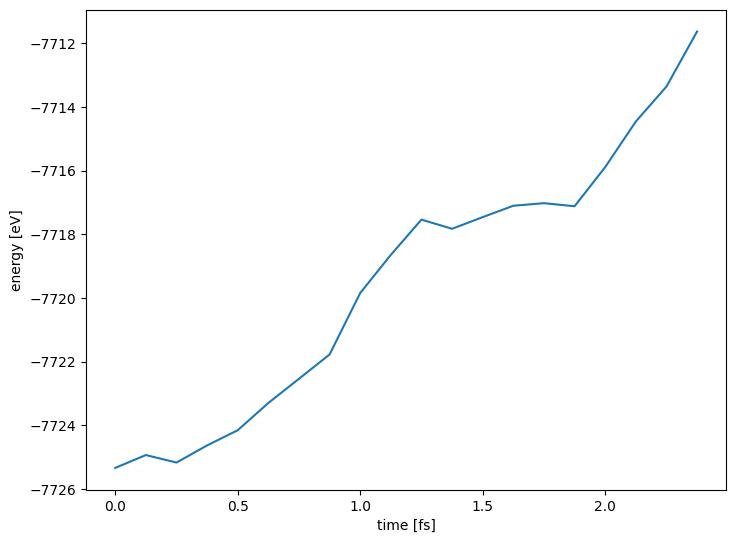

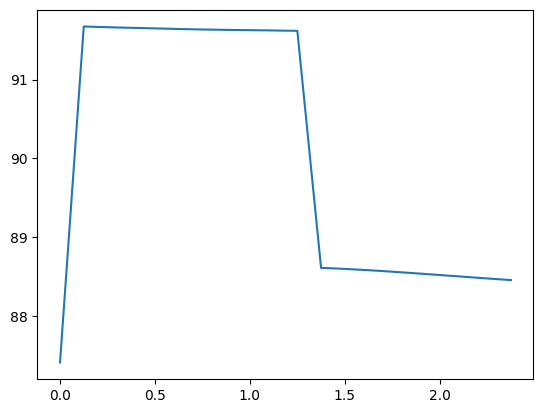

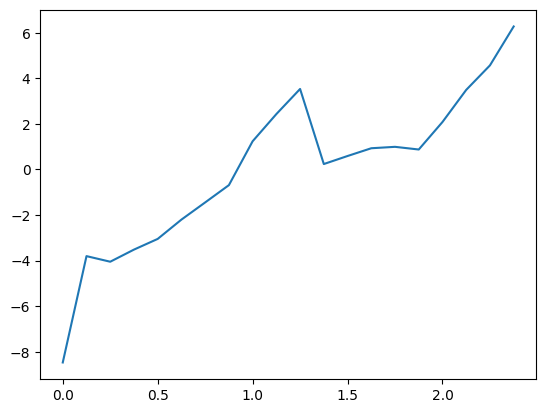

In [1839]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time, te, label='total energy')
plt.show()
# plt.legend()
# plt.grid()

(array([7., 2., 2., 2., 1., 1., 1., 2., 0., 2.]),
 array([-0.42450104, -0.29961395, -0.17472687, -0.04983978,  0.0750473 ,
         0.19993439,  0.32482147,  0.44970856,  0.57459564,  0.69948273,
         0.82436981]),
 <BarContainer object of 10 artists>)

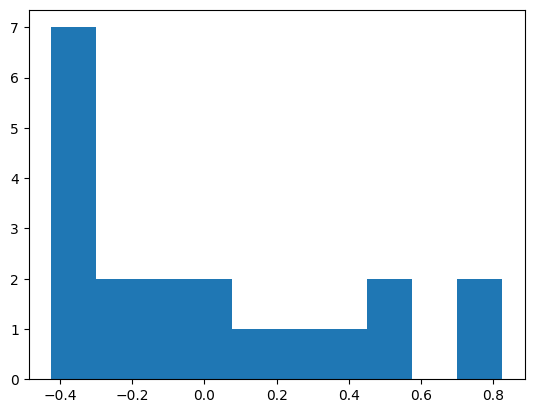

In [1835]:
plt.hist(total_energy - total_energy.mean())